# Deep Learning for Detecting Pneumonia from X-ray Images

## Convolutional Neural Network

Building an algorithm to automatically identify whether a patient is suffering from pneumonia or not by looking at chest X-ray images.
The accuracy of the model built is extremely important as lives of people is at stake.

The minimum accuracy accepted is 90%.

## I - Imports

In [1]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import accuracy_score, confusion_matrix

seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

## II - Load datasets

**Dataset Normal/Pneumonia**

In [2]:
result = []

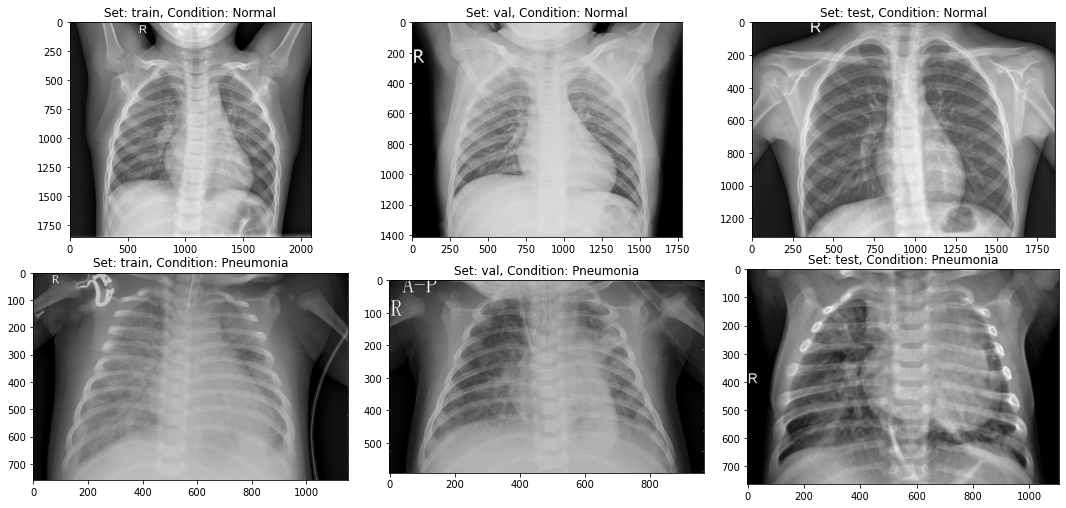

In [44]:
input_path = '../dataset/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [45]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1341, pneumonia images: 3875
Set: val, normal images: 8, pneumonia images: 8
Set: test, normal images: 234, pneumonia images: 390


**Dataset Bacteria/Virus**

## III - Create the model

In [46]:
img_dims = 150
epochs = 20
batch_size = 32

In [47]:
inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

## IV - Normal/Pneumonia Model

### 1 - Process data

In [48]:
def process_data(img_dims, batch_size):
    #
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # 
    train_gen = train_datagen.flow_from_directory(
        directory=input_path+'train', 
        target_size=(img_dims, img_dims), 
        batch_size=batch_size, 
        class_mode='binary', 
        shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
        directory=input_path+'test', 
        target_size=(img_dims, img_dims), 
        batch_size=batch_size, 
        class_mode='binary', 
        shuffle=True)
    
    #
    test_data = []
    test_labels = []

    #
    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [49]:
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### 2 - Train Model

In [50]:
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.AUC(name='AUC')]

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [51]:
hist = model.fit(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/20
163/163 [==============================] - 117s 701ms/step - loss: 0.3626 - accuracy: 0.8372 - precision: 0.8752 - recall: 0.9107 - fn: 346.0000 - fp: 503.0000 - tn: 838.0000 - tp: 3529.0000 - AUC: 0.8924 - val_loss: 0.6631 - val_accuracy: 0.6266 - val_precision: 0.6266 - val_recall: 1.0000 - val_fn: 0.0000e+00 - val_fp: 227.0000 - val_tn: 0.0000e+00 - val_tp: 381.0000 - val_AUC: 0.5000 - lr: 0.0010
Epoch 2/20
163/163 [==============================] - 113s 689ms/step - loss: 0.2815 - accuracy: 0.8825 - precision: 0.9345 - recall: 0.9053 - fn: 367.0000 - fp: 246.0000 - tn: 1095.0000 - tp: 3508.0000 - AUC: 0.9348 - val_loss: 0.6674 - val_accuracy: 0.6266 - val_precision: 0.6266 - val_recall: 1.0000 - val_fn: 0.0000e+00 - val_fp: 227.0000 - val_tn: 0.0000e+00 - val_tp: 381.0000 - val_AUC: 0.7731 - lr: 0.0010
Epoch 3/20
163/163 [==============================] - 110s 675ms/step - loss: 0.2687 - accuracy: 0.8924 - precision: 0.9414 - recall: 0.9120 - fn: 341.0000 - fp: 220.0000 

### 3 - Metrics, stats and confusion matrix

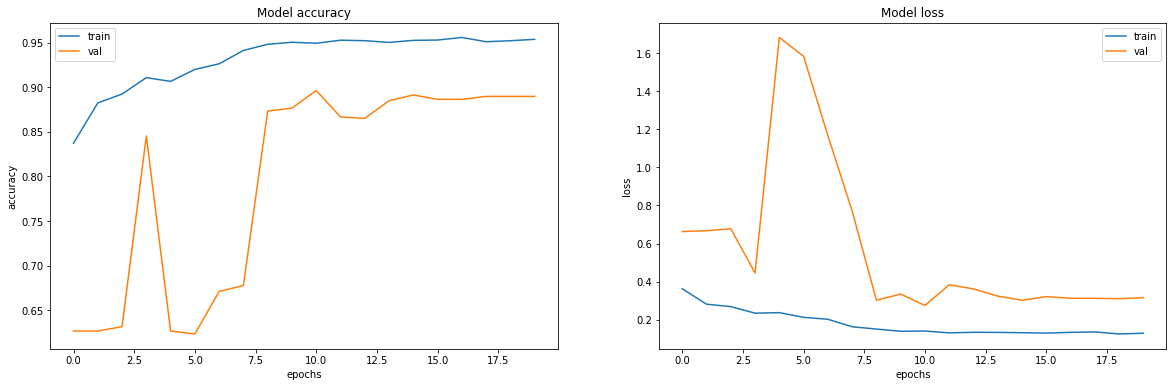

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [65]:
preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('METRICS----------------------')
print('True Neg: ', tn)
print('False Pos: ',fp)
print('False Neg: ', fn)
print('True Pos: ', tp)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[173  61]
 [ 10 380]]
METRICS----------------------
True Neg:  173
False Pos:  61
False Neg:  10
True Pos:  380

TEST METRICS ----------------------
Accuracy: 88.62179487179486%
Precision: 86.16780045351474%
Recall: 97.43589743589743%
F1-score: 91.45607701564381

TRAIN METRIC ----------------------
Train acc: 95.38


In [54]:
result.append(["dataset_small", acc, precision, recall, fn, fp, tp, tn])

In [55]:
result

[['dataset_normal',
  89.42307692307693,
  88.02816901408451,
  96.15384615384616,
  15,
  51,
  375,
  183],
 ['dataset_small', 62.5, 62.5, 100.0, 0, 234, 390, 0],
 ['dataset_small',
  88.62179487179486,
  86.16780045351474,
  97.43589743589743,
  10,
  61,
  380,
  173]]

In [56]:
ds_nm ={'acc': 89.4, 'precision': 88.0, 'recall': 96.1, 'fn': 15, 'fp': 51, 'tp': 375, 'tn': 183}
ds_sm ={'acc': 62.5, 'precision': 62.5, 'recall': 100.0, 'fn': 0, 'fp': 234, 'tp': 390, 'tn': 0}

compare = {"Normal dataset": ds_nm, "Small dataset": ds_sm}

df = pd.DataFrame(data=compare)
df

,Normal dataset,Small dataset
acc,89.4,62.5
precision,88.0,62.5
recall,96.1,100.0
fn,15.0,0.0
fp,51.0,234.0
tp,375.0,390.0
tn,183.0,0.0


In [64]:
print('--------- CONFUSION MATRIX ---------')
print(cm)
print('\n----------- TEST METRICS -----------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\n----------- TRAIN METRIC -----------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

--------- CONFUSION MATRIX ---------
[[173  61]
 [ 10 380]]

----------- TEST METRICS -----------
Accuracy: 88.62179487179486%
Precision: 86.16780045351474%
Recall: 97.43589743589743%
F1-score: 91.45607701564381

----------- TRAIN METRIC -----------
Train acc: 95.38
